# Building a Footwear Classifier with Transfer Learning

## Introduction

In this Colab, we will first build a **convolutional neural network** from scratch.

We will then use **Transfer Learning** to see if we can get higher accuracy in our image classification models.



**Footwear Classes:**
1. Sneakers

2. Boots

3. Sandles

4. Heels

5. [NONE]



In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

Unlike the earlier colab where we used a dataset that comes packaged with Keras, in this colab we will work with our own data.

I have web-scraped approximately 300 color images each of sneakers, sandles, boots, and heels, packaged it up as a zip file and placed it in Dropbox.

The code below downloads this zip file and unzips it so that colab can access it.

In [ ]:
!wget -q -O shoes.zip "https://www.dropbox.com/scl/fi/18gaj9stbrxrvmy6af0b6/shoes.zip?rlkey=8edglpkr7h7jnxfem3o5sq9xh&st=ppky7iib&dl=0"
!unzip -qq shoes.zip


## Data Pre-processing



---



---

Since this isn't a standard Keras dataset, we will need to split it into train/validation/test sets ourselves.    

In [ ]:
import os, shutil, pathlib

base_dir = pathlib.Path("/content/shoes")


In [ ]:
for category in ('boots_images', 'heels_images', 'misc_images','sandles_images','sneaker_images'):
  fnames = os.listdir(base_dir/category)

  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:150]:    # the first 150 examples go into the training set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[150:210]:  # the next 60 examples go into the validation set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[210:]:    # the remaining examples go into the test set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)


When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))


In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 731 files belonging to 5 classes.
Found 240 files belonging to 5 classes.
Found 278 files belonging to 5 classes.


This means there are 731 images for training, 240 images for validation, and 278 images for testing.

Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [ ]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


Check!

Let's look at a few examples.

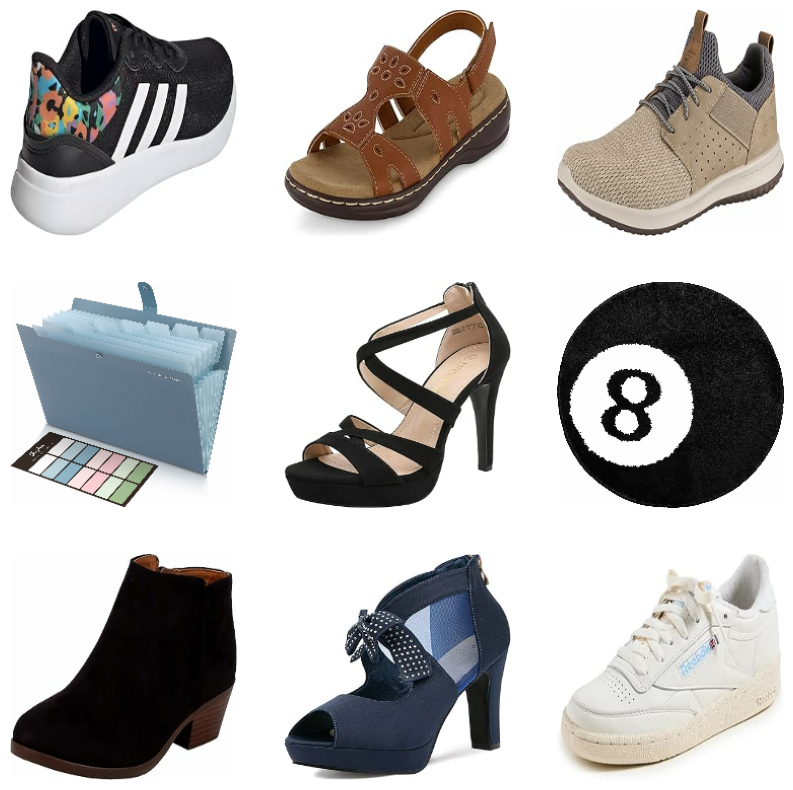

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## A Basic Convolutional Neural Network



---



---



We will try a simple CNN on this dataset with two convolutional blocks.

In [ ]:
# each image has a shape of 224x224 pixels and there are 3 RGB channels
input = keras.Input(shape=(224,224,3))

# we normalize "inside" the model with a Rescaling layer
# so that we don't have to remember to do it every time
# we need to use the model to make a prediction
h = keras.layers.Rescaling(1./255)(input)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_1")(h)
# Max pool
h = keras.layers.MaxPool2D()(h)


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_2")(h)

# Max pool
h = keras.layers.MaxPool2D()(h)

# flatten layer
# data is flattened from a 3D volume into a 1D vector
h = keras.layers.Flatten()(h)

# output layer with 3 classes
output = keras.layers.Dense(5, activation="softmax")(h)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 Conv_2 (Conv2D)             (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                        

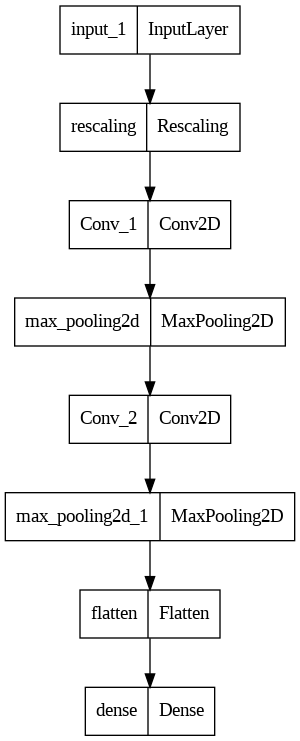

In [ ]:
keras.utils.plot_model(model)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

As usual, we will tell Keras to track loss and accuracy on the **validation** set so we can keep an eye on any overfitting.

We will also store the results of running `model.fit` in the variable `history`. This will allow us to plot how the loss and accuracy changed from epoch to epoch etc. and thereby get a sense for any overfitting.

In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
23/23 [==============================] - 8s 173ms/step - loss: 2.3627 - accuracy: 0.3680 - val_loss: 1.3066 - val_accuracy: 0.6458
Epoch 2/20
23/23 [==============================] - 3s 114ms/step - loss: 0.8496 - accuracy: 0.7456 - val_loss: 0.8774 - val_accuracy: 0.7208
Epoch 3/20
23/23 [==============================] - 3s 117ms/step - loss: 0.4971 - accuracy: 0.8536 - val_loss: 0.7205 - val_accuracy: 0.7750
Epoch 4/20
23/23 [==============================] - 4s 147ms/step - loss: 0.2999 - accuracy: 0.9207 - val_loss: 0.6651 - val_accuracy: 0.7625
Epoch 5/20
23/23 [==============================] - 3s 114ms/step - loss: 0.1849 - accuracy: 0.9494 - val_loss: 0.6668 - val_accuracy: 0.7875
Epoch 6/20
23/23 [==============================] - 3s 115ms/step - loss: 0.1182 - accuracy: 0.9754 - val_loss: 0.7487 - val_accuracy: 0.8042
Epoch 7/20
23/23 [==============================] - 4s 148ms/step - loss: 0.0731 - accuracy: 0.9836 - val_loss: 0.7195 - val_accuracy: 0.8000
Epoch 

In [ ]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

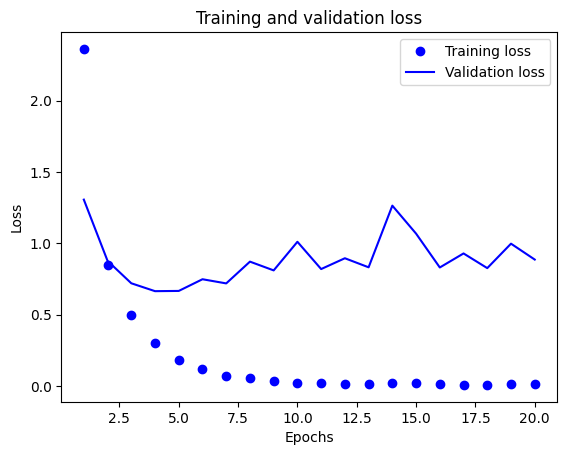

In [ ]:
plot_loss_curves(history)

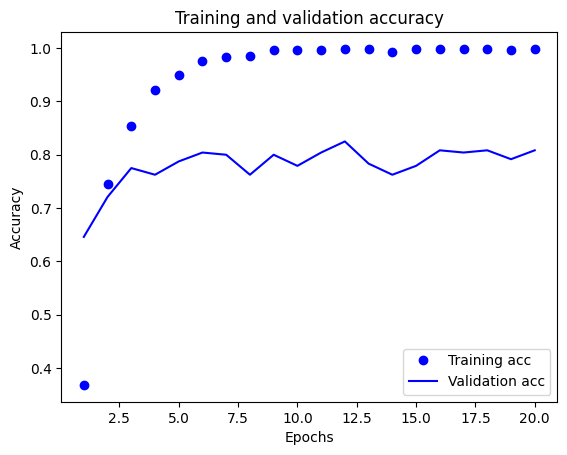

In [ ]:
plot_acc_curves(history)

There's a small gap between training and validation accuracy curves, suggesting **overfitting**.




Let's check the accuracy on the test set.

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 1s 41ms/step - loss: 0.9120 - accuracy: 0.8058


[0.9120315313339233, 0.8057553768157959]

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



The primary goal of data augmentation is not necessarily to improve raw accuracy metrics but to enhance the model's ability to generalize to new, unseen data by reducing overfitting.

By using data augmentation, you're effectively making the training process more challenging and diverse, forcing the model to learn more generalized, robust features that are useful across varied inputs, not just the training set.

To demonstrate, here's a little function that applies three transformations to an incoming image.


In [ ]:
def augment_data(image):
  x = keras.layers.RandomFlip("horizontal")(image)
  x = keras.layers.RandomRotation(0.1)(x)
  x = keras.layers.RandomZoom(0.2)(x)
  return x

Let's apply it to an image from our training set to see what it produces.

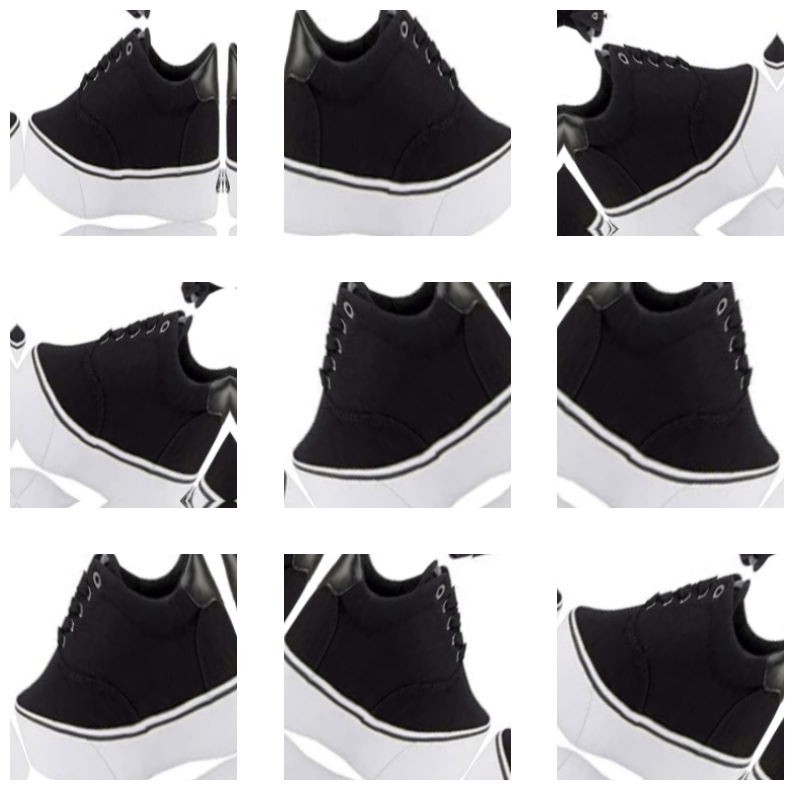

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")

We can insert these  data augmentation layers right after the input layer in the convolutional NN model we built earlier, and train the model as before. Also, because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

In [ ]:
input = keras.Input(shape=(224,224,3))

# we insert the data augmentation layers here
h = keras.layers.RandomFlip("horizontal")(input)
h = keras.layers.RandomRotation(0.1)(h)
h = keras.layers.RandomZoom(0.2)(h)

# rest of the model is the same as before

h = keras.layers.Rescaling(1./255)(h)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_1")(h)
h = keras.layers.MaxPool2D()(h)


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_2")(h)
h = keras.layers.MaxPool2D()(h)

# flatten layer
h = keras.layers.Flatten()(h)

# output layer
output = keras.layers.Dense(5, activation="softmax")(h)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_9 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Conv_1 (Conv2D)             (None, 223, 223, 32)      416       
                                                           

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
23/23 [==============================] - 6s 144ms/step - loss: 2.8745 - accuracy: 0.2503 - val_loss: 1.5868 - val_accuracy: 0.3000
Epoch 2/20
23/23 [==============================] - 3s 117ms/step - loss: 1.4480 - accuracy: 0.4159 - val_loss: 1.5253 - val_accuracy: 0.4458
Epoch 3/20
23/23 [==============================] - 3s 118ms/step - loss: 1.2665 - accuracy: 0.5363 - val_loss: 1.4235 - val_accuracy: 0.4750
Epoch 4/20
23/23 [==============================] - 5s 170ms/step - loss: 1.1460 - accuracy: 0.5882 - val_loss: 1.1798 - val_accuracy: 0.5417
Epoch 5/20
23/23 [==============================] - 4s 120ms/step - loss: 1.0678 - accuracy: 0.6252 - val_loss: 1.0227 - val_accuracy: 0.6792
Epoch 6/20
23/23 [==============================] - 4s 154ms/step - loss: 1.0255 - accuracy: 0.6211 - val_loss: 0.8857 - val_accuracy: 0.7167
Epoch 7/20
23/23 [==============================] - 4s 138ms/step - loss: 0.9731 - accuracy: 0.6553 - val_loss: 0.8862 - val_accuracy: 0.7292
Epoch 

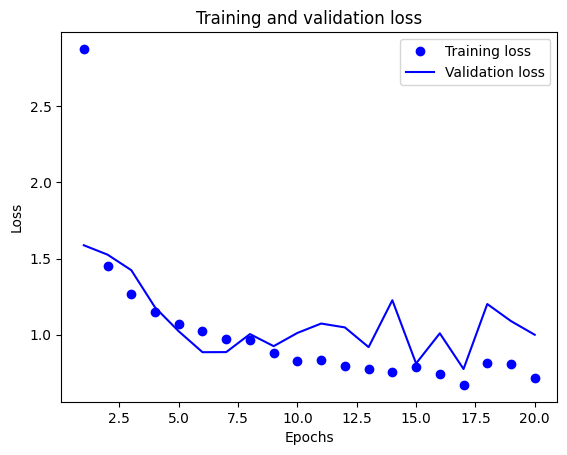

In [ ]:
plot_loss_curves(history)

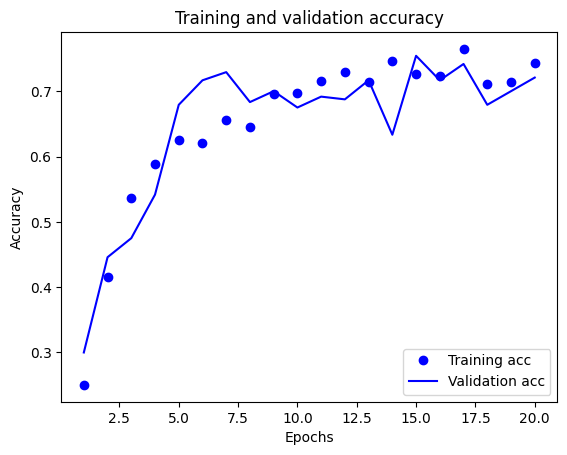

In [ ]:
plot_acc_curves(history)

In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 1s 18ms/step - loss: 1.0136 - accuracy: 0.6978


[1.0135554075241089, 0.6978417038917542]

From this trial, we see that the test set accuracy actually decreased although there is less overfitting.

## Model built with Transfer Learning


**SWITCH TO PPT FOR TRANSFER LEARNING**




---

We will work with ResNet-50 (rather than ResNet-34 as shown in the picture below) since it comes pre-packaged with Keras.

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub).



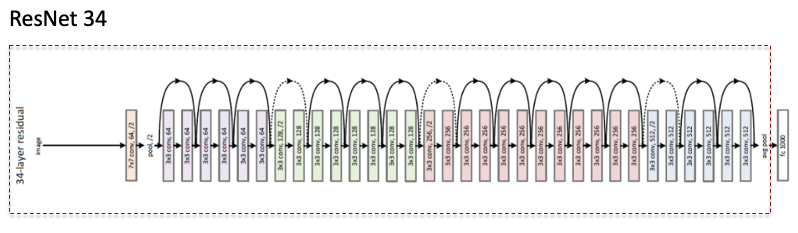

In [ ]:
# Get top off

resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

By removing the top layers, you can add your own layers tailored to your particular problem or dataset, which may have a different number of classes.

The initial layers of a convolutional network capture generic features (like edges, textures, and shapes) that are applicable to a wide variety of tasks, while the deeper layers become progressively more specific to the details of the classes contained in the original training dataset.

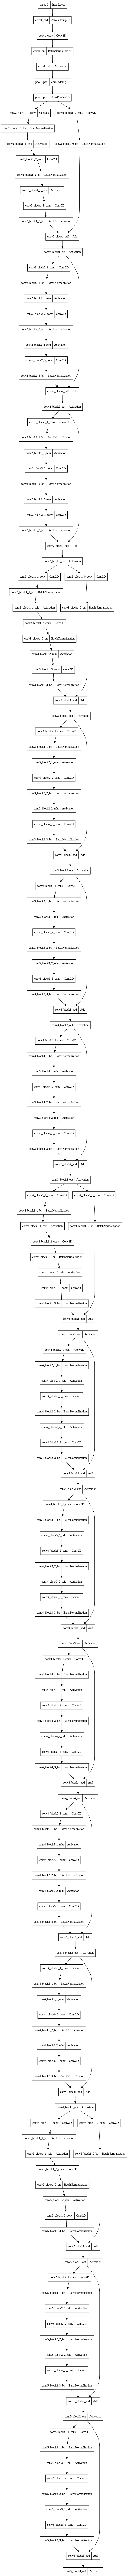

In [ ]:
keras.utils.plot_model(resnet50_base)

It is a **DEEP** network, all right!!

Next, we run our dataset through "headless ResNet" to get the transformed, "smart" inputs.


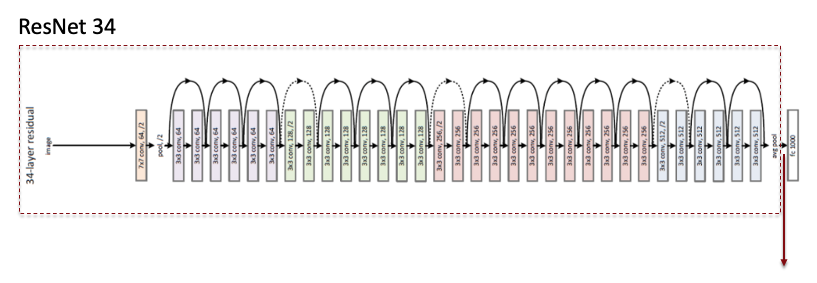

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


What's the shape of the tensor that comes out of 'headless' ResNet?

In [ ]:
train_features.shape

(731, 7, 7, 2048)

These tensors coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN.  

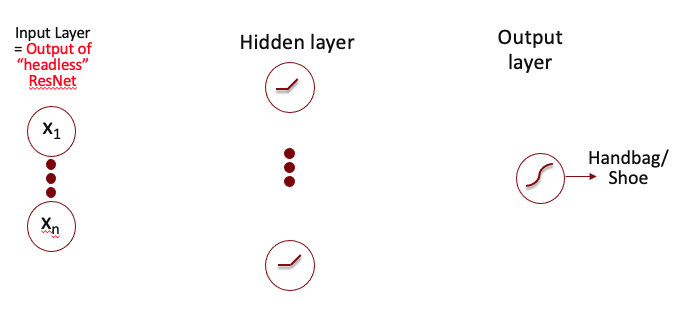


We will use a regularization layer that we haven't yet used: `Dropout`.

In [ ]:
input = keras.Input(shape=(7, 7, 2048))

h = keras.layers.Flatten()(input)

h = keras.layers.Dense(256, activation="relu")(h)

h = keras.layers.Dropout(0.5)(h)

output = keras.layers.Dense(5, activation="softmax")(h)

model = keras.Model(input, output)

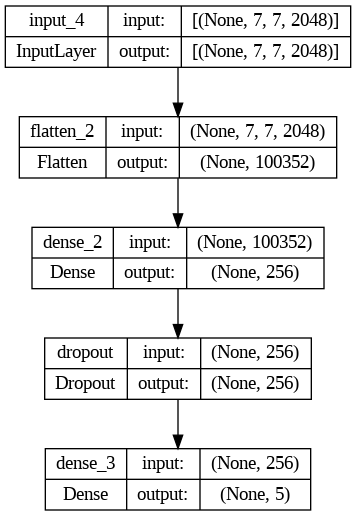

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 25691653 (98.01 MB)
Trainable params: 25691653 (98.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    validation_data=(val_features, val_labels))

Epoch 1/20
23/23 [==============================] - 3s 37ms/step - loss: 9.1296 - accuracy: 0.7702 - val_loss: 2.8406 - val_accuracy: 0.8792
Epoch 2/20
23/23 [==============================] - 1s 22ms/step - loss: 1.6576 - accuracy: 0.9357 - val_loss: 2.4499 - val_accuracy: 0.9125
Epoch 3/20
23/23 [==============================] - 0s 18ms/step - loss: 0.8716 - accuracy: 0.9576 - val_loss: 2.0120 - val_accuracy: 0.9208
Epoch 4/20
23/23 [==============================] - 0s 18ms/step - loss: 0.9729 - accuracy: 0.9535 - val_loss: 1.3725 - val_accuracy: 0.9292
Epoch 5/20
23/23 [==============================] - 0s 22ms/step - loss: 0.6297 - accuracy: 0.9713 - val_loss: 1.8409 - val_accuracy: 0.9250
Epoch 6/20
23/23 [==============================] - 0s 18ms/step - loss: 0.6642 - accuracy: 0.9672 - val_loss: 1.4478 - val_accuracy: 0.9458
Epoch 7/20
23/23 [==============================] - 0s 18ms/step - loss: 0.4587 - accuracy: 0.9699 - val_loss: 1.3024 - val_accuracy: 0.9375
Epoch 8/20
23

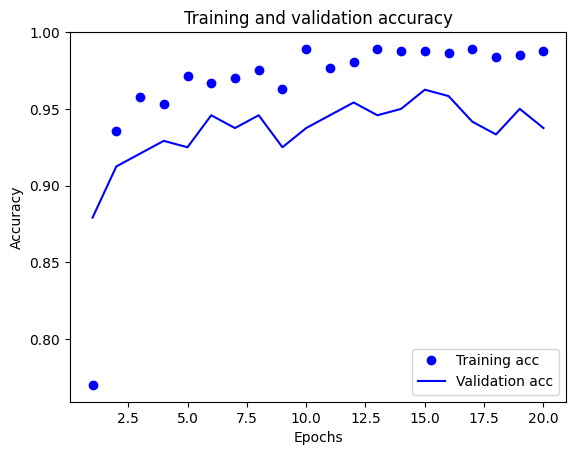

In [ ]:
plot_acc_curves(history)

The training and validation accuracies are both very high! This looks promising!

In [ ]:
model.evaluate(test_features, test_labels)

9/9 [==============================] - 0s 8ms/step - loss: 1.2245 - accuracy: 0.9209


[1.2244576215744019, 0.9208633303642273]

OK, let's test it **LIVE** with the laptop's webcam.

In [ ]:
# Camera Capture code snippet courtesy Google Colab


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [ ]:
from google.colab.patches import cv2_imshow
from IPython.display import display, HTML


# In order of the training images
class_names = ['boots', 'heels', 'misc', 'sandles', 'sneakers']

def predict_image(im):
    img = keras.preprocessing.image.load_img(im, target_size=(224, 224))
    arr = keras.preprocessing.image.img_to_array(img)
    arr = keras.applications.resnet50.preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)
    arr = resnet50_base(arr)

    pred = model.predict(arr)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred)

    # Convert confidence to percentage
    confidence_percent = confidence * 100

    # Check if the confidence is below the threshold
    if predicted_class == "misc":
      print(confidence)
      display(HTML(f"<h1>It's not a shoe!</h1>"))

    else:
      display(HTML(f"<h1>Prediction: {predicted_class} with confidence {confidence_percent:.2f}%</h1>"))



<IPython.core.display.Javascript object>

Saved to photo.jpg


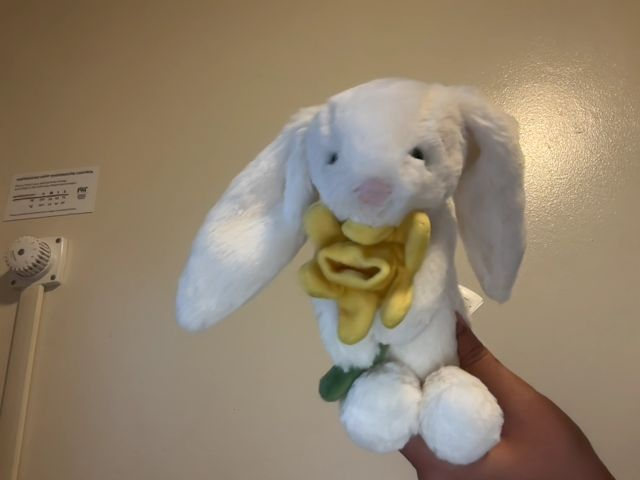

1/1 [==============================] - 0s 31ms/step
1.0


In [ ]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))